# Proyecto: RecRoyale

## Integrantes:

- Benjamín Farías V.
- Benjamín Lepe M.
- Juan Romero R.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model

# Set random seeds
np.random.seed(1)
tf.random.set_seed(2)

# Config
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Load cards dataset
cards_dataset = pd.read_csv('datasets/CardMasterListSeason18_12082020.csv', sep=',')
cards_dataset

,team.card1.id,team.card1.name
0,26000000,Knight
1,26000001,Archers
2,26000002,Goblins
3,26000003,Giant
4,26000004,P.E.K.K.A
...,...,...
97,28000014,Earthquake
98,28000015,Barbarian Barrel
99,28000016,Heal Spirit
100,28000017,Giant Snowball


In [4]:
# Card names list
card_names = cards_dataset['team.card1.name']
print(card_names)

# Map card name to index and viceversa
card_name_to_idx = dict()
idx_to_card_name = dict()
for index, card in enumerate(card_names):
    card_name_to_idx[card] = index
    idx_to_card_name[index] = card


# Map card id to index in names list
card_id_to_idx = dict()
for index, card in cards_dataset.iterrows():
    card_id_to_idx[card['team.card1.id']] = index

0                Knight
1               Archers
2               Goblins
3                 Giant
4             P.E.K.K.A
             ...       
97           Earthquake
98     Barbarian Barrel
99          Heal Spirit
100      Giant Snowball
101      Royal Delivery
Name: team.card1.name, Length: 102, dtype: object


In [5]:
# Load dataset in batches
def load_data(dataset_path, idx, batch_size):
    # Preprocessing
    rows = None
    if idx:
        rows = range(1, idx * batch_size + 1)
    df = pd.read_csv(dataset_path, sep=',', skiprows=rows, nrows=batch_size)
    for c_idx in range(1, 9):  # Map card ids + levels to indexes for faster operations
        df[f'winner.card{c_idx}'] = df[f'winner.card{c_idx}.id'].map(lambda c: card_id_to_idx[c]) * 14 + df[f'winner.card{c_idx}.level'] - 1
        df[f'loser.card{c_idx}'] = df[f'loser.card{c_idx}.id'].map(lambda c: card_id_to_idx[c]) * 14 + df[f'loser.card{c_idx}.level'] - 1
    df['crowns'] = df['winner.crowns'] - df['loser.crowns']  # Get crown difference
    useful_columns = []  # Filter useful columns
    x_columns = []
    y_columns = []
    for player in ('loser', 'winner'):
        for c_idx in range(1, 9):
            if player == 'loser':
                x_columns.append(f'{player}.card{c_idx}')
            else:
                y_columns.append(f'{player}.card{c_idx}')
            useful_columns.append(f'{player}.card{c_idx}')
    y_columns.append('crowns')
    useful_columns.append('crowns')
    combat_data = df[useful_columns]

    # X values
    input_data = combat_data[x_columns].to_numpy()
    X = []
    for example in input_data:
        current_x = [1 if n in example else 0 for n in range(1428)]
        X.append(current_x)
    X = np.array(X).reshape(len(X), 1428)

    # Y values
    true_data = combat_data[y_columns].to_numpy()
    Y = []
    for example in true_data:
        current_y = [1 if n in example[:-1] else 0 for n in range(1428)]
        current_y.append(example[-1])
        Y.append(current_y)
    Y = np.array(Y).reshape(len(Y), 1429)

    return X, Y

# Generate batches
def batch_generator(dataset_path, batch_size, steps):
    idx = 1
    while True:
        yield load_data(dataset_path, idx - 1, batch_size)
        if idx < steps:
            idx += 1
        else:
            idx = 1

In [6]:
# Prepare data for training
batch_size = 256
train_path = 'datasets/train/train.csv'
train_steps = np.ceil(32000 / batch_size)  # We use 32000 rows for 4 epochs
train_generator = batch_generator(train_path, batch_size, train_steps)

# Prepare data for validation
val_path = 'datasets/val/val.csv'  # We use 8192 rows for 4 epochs
val_steps = np.ceil(8192 / batch_size)
val_generator = batch_generator(val_path, batch_size, val_steps)

In [7]:
# Generate model
def generate_model(layers):
    m = Sequential()
    m.add(Dense(layers[0], input_shape=(1428,), activation='relu'))
    name = f'RoyaleNet_{layers[0]}'
    for layer in layers[1:]:
        m.add(Dense(layer, activation='relu'))
        name += f'_{layer}'
    m.add(Dense(1428, activation='sigmoid'))
    return m, name

In [8]:
# Loss function (Binary Cross-Entropy)
def binary_loss(y_true, y_pred):
    cards_loss = tf.keras.losses.binary_crossentropy(y_true[:,:-1], y_pred)
    return cards_loss * (1 + 0.3 * y_true[:,-1])

# Binary accuracy (cards in common with target)
def binary_acc(y_true, y_pred):
    cards_acc = tf.keras.metrics.binary_accuracy(y_true[:,:-1], y_pred, threshold=0.1)
    return cards_acc

In [9]:
# Obtain model
hidden_layers_a = [3000]
hidden_layers_b = [10000]
hidden_layers_c = [3000, 2000]
hidden_layers_d = [2000, 5000]
hidden_layers_e = [2000, 5000, 2000]
model, model_name = generate_model(hidden_layers_b)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10000)             14290000  
_________________________________________________________________
dense_1 (Dense)              (None, 1428)              14281428  
Total params: 28,571,428
Trainable params: 28,571,428
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile
model.compile(optimizer='adam', loss=binary_loss, metrics=[binary_acc])

In [11]:
# Train
history = model.fit(train_generator, epochs=5, steps_per_epoch=train_steps, validation_data=val_generator, validation_steps=val_steps)

Epoch 1/5
125/125 [==============================] - 241s 2s/step - loss: 0.1794 - binary_acc: 0.7720 - val_loss: 0.0296 - val_binary_acc: 0.9853
Epoch 2/5
125/125 [==============================] - 239s 2s/step - loss: 0.0290 - binary_acc: 0.9842 - val_loss: 0.0293 - val_binary_acc: 0.9853
Epoch 3/5
125/125 [==============================] - 239s 2s/step - loss: 0.0286 - binary_acc: 0.9839 - val_loss: 0.0292 - val_binary_acc: 0.9852
Epoch 4/5
125/125 [==============================] - 239s 2s/step - loss: 0.0283 - binary_acc: 0.9838 - val_loss: 0.0293 - val_binary_acc: 0.9850
Epoch 5/5
125/125 [==============================] - 238s 2s/step - loss: 0.0281 - binary_acc: 0.9838 - val_loss: 0.0294 - val_binary_acc: 0.9848


dict_keys(['loss', 'binary_acc', 'val_loss', 'val_binary_acc'])


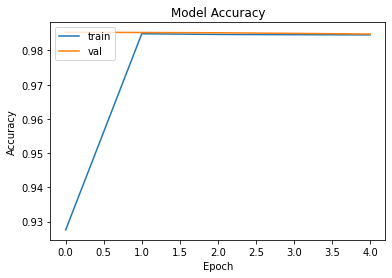

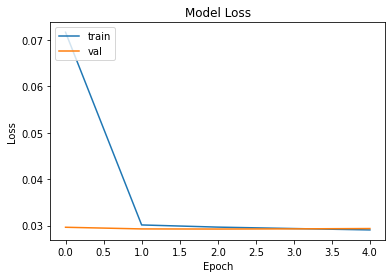

In [12]:
# Analyze history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['binary_acc'])
plt.plot(history.history['val_binary_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
# Save model
model.save(f'{model_name}.h5')

### Análisis de parámetros:

RoyaleNet @3000 - Acc: 0.9850, Loss: 0.0292 -> 2

RoyaleNet @10000 - Acc: 0.9853, Loss: 0.0293 -> 1

RoyaleNet @3000+2000 - Acc: 0.9843, Loss: 0.0293 -> 3

RoyaleNet @2000+5000 - Acc: 0.9842, Loss: 0.0292 -> 4

RoyaleNet @2000+5000+2000 - Acc: 0.9843, Loss: 0.0294 -> 5

(2 épocas para evitar overfitting)

In [ ]:
# Prepare data for testing
test_path = 'datasets/test/test.csv'
test_steps = np.ceil(8192 / batch_size)
test_generator = batch_generator(test_path, batch_size, test_steps)

In [ ]:
# Random model (for comparison)
random, rand_name = generate_model([10000])
random.compile(optimizer='adam', loss=binary_loss, metrics=[binary_acc])
random.evaluate(test_generator, steps=test_steps)

32/32 [==============================] - 50s 2s/step - loss: 0.9666 - binary_acc: 0.0056


[0.9739462733268738, 0.005602241028100252]

In [ ]:
# Load saved models for testing
test_model = load_model('RoyaleNet_10000.h5', custom_objects={'binary_loss': binary_loss, 'binary_acc': binary_acc})
test_model.compile(optimizer='adam', loss=binary_loss, metrics=[binary_acc])

In [ ]:
# Testing
test_model.evaluate(test_generator, steps=test_steps)

32/32 [==============================] - 50s 2s/step - loss: 0.0286 - binary_acc: 0.9837


[0.02910744585096836, 0.9839659929275513]

### Resultados de Experimentos:

Random - Acc: 0.0056, Loss: 0.973 -> 6

RoyaleNet @3000 - Acc: 0.984, Loss: 0.0289 -> 5

RoyaleNet @10000 - Acc: 0.985, Loss: 0.029 -> 1

RoyaleNet @3000+2000 - Acc: 0.984, Loss: 0.0284 -> 4

RoyaleNet @2000+5000 - Acc: 0.984, Loss: 0.029 -> 2

RoyaleNet @2000+5000+2000 - Acc: 0.984, Loss: 0.029 -> 3

In [ ]:
# Evaluation in practice
eval_model = load_model('RoyaleNet_10000.h5', custom_objects={'binary_loss': binary_loss, 'binary_acc': binary_acc})
eval_model.compile(optimizer='adam', loss=binary_loss, metrics=[binary_acc])

In [ ]:
# Model in practice: input - 8 cards from opponent, output - 8 cards for you
def get_prediction(model, opponent):
    x_input = [0] * 1428
    for card_name in opponent:
        idx = card_name_to_idx[card_name] * 14 + 14 - 1
        x_input[idx] = 1
    X = [x_input]
    X = np.array(X).reshape(len(X), 1428)
    pred = model.predict(X)[0]
    ranking = np.argsort(pred)[::-1]
    predicted_cards = []
    for card_idx in ranking:
        c_name = idx_to_card_name[np.floor(card_idx / 14)]
        if c_name not in predicted_cards and len(predicted_cards) < 8:
            predicted_cards.append(c_name)
    return sorted(predicted_cards)

In [ ]:
# Examples
print(get_prediction(eval_model, ['Witch', 'Valkyrie', 'Skeleton Army', 'Inferno Dragon', 'Mega Knight', 'Wall Breakers', 'Goblin Barrel', 'The Log']))

['Arrows', 'Baby Dragon', 'Fireball', 'Hog Rider', 'Knight', 'The Log', 'Valkyrie', 'Zap']


In [ ]:
print(get_prediction(eval_model, ['Knight', 'Skeleton Army', 'Princess', 'Dart Goblin', 'Skeleton Barrel', 'Inferno Tower', 'Goblin Barrel', 'The Log']))

['Arrows', 'Fireball', 'Knight', 'Mini P.E.K.K.A', 'Skeleton Army', 'The Log', 'Valkyrie', 'Zap']


In [ ]:
print(get_prediction(eval_model, ['Valkyrie', 'Tornado', 'Zap', 'Ice Spirit', 'Miner', 'Balloon', 'Skeletons', 'Executioner']))

['Arrows', 'Fireball', 'Hog Rider', 'Knight', 'Skeleton Army', 'The Log', 'Valkyrie', 'Zap']
